# Fast & Furious & Autonomous : Self Driving Car Laboratory ECAM 2019
## Authors : Hubert Mugabo Pitie - Salim Boutlendj

## Libraries 

- Tensorflow : Machine learning library (For this project a GPU version was used)
- Keras : High-level neural networks API for Deep learnings that uses Tensorflow as a backend
- CV2 : Image Processing library.
- Pandas : Library used for data stucture and data analysis (Handle the dataset csv file)
- imgaug : Library used for image aumgmentation, to easily generate images from exsitant ones through image tranformations technics.
- Sklearn : Machine learning library used to efficiently split our dataset to train and validattion sets and also to shufle through learning process.
- Matplotlib : A library used to display graphics and images from the data that are manipulated.




## Installation 


### MacOS Linux

```bash
python -m pip install -r requierments.txt
```



### Windows 

Shapely is a library used by imgaug needs to be installed manually using the [.whl file](https://www.lfd.uci.edu/~gohlke/pythonlibs/#shapely)

Then install the requierments : 
```bash
python -m pip install -r requierments.txt
```

### How To Run 

For the training Open the notebook on Jupyter
```bash
jupyter notebook 'Fast & Furious & Autonomous.ipynb'

```
Then execute all the cells

To test our final model open the simulator on the track you want to c


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


## Dataset 

The dataset is generated using the udacity self driving simulator. It stores every frame while recording through 3 cameras (left, center, right), it also saves a .csv file of all actions taken by the driver (steering, throttle, reverse, speed)  

- Speed : a value between [0,30] expressing mph
- Throttle : a value between [0.0, 1.0], 1 means not throttling at all
- Steering : [-1.0, 1.0] where the extreme values are [left, right] and 0 is straight

In [2]:
datadir = '..\Map2_Hybrid'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_637.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_637.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_637.jpg,0.0,0.580278,0.0,0.555763
1,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_707.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_707.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_707.jpg,0.0,0.816568,0.0,1.197916
2,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_777.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_777.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_777.jpg,0.0,0.997550,0.0,1.831465
3,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_846.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_846.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_846.jpg,0.0,1.000000,0.0,2.716950
4,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_914.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_914.jpg,C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_914.jpg,0.0,1.000000,0.0,3.379713


### Data distribution

With this histogram we want to display the distribution of the steering angles of our dataset. We concluded that our dataset is not well balanced and it may lead to a false learning since we have nearly 14000 '0' values our model will likely tend to go straight.

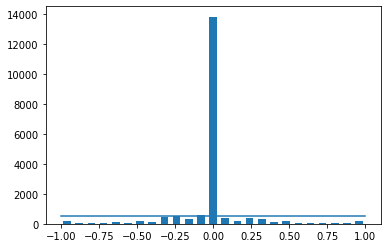

In [3]:
max_bars = 25
treshold = 500
hist, bars = np.histogram(data['steering'], max_bars)
center = (bars[:-1]+ bars[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (treshold, treshold))

### Data Cleaning
Thus we decided to only keep 500 '0' values. This treshold results from testing differents value starting from 3500 and reducing, the feedback was the behaviour of our model in the simulator he tends to ignore some bends and not turning at the right time.

total data: 18590
removed: 13423
remaining: 5167


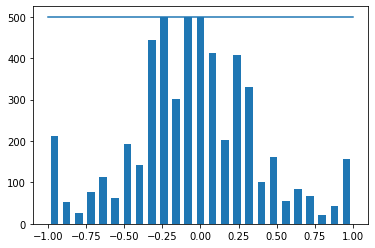

In [4]:
print('total data:', len(data))
remove_list = []
for j in range(max_bars):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bars[j] and data['steering'][i] <= bars[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[treshold:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (max_bars))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (treshold, treshold))

In [5]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()[-34:]))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()[-32:]))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()[-33:]))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_46_679.jpg
left        C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_46_679.jpg  
right       C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_46_679.jpg 
steering    0.2                                                                      
throttle    1                                                                        
reverse     0                                                                        
speed       11.5902                                                                  
Name: 15, dtype: object


### Data slipting (Train-Test)

We devided our dataset to train-test using the train_test_split function provided by sklearn lib.

Definition of arguments : 
    
   - test_size : The size in percentage of the test dataset 0.2 means 20%
   - random_state : 
        

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 12400
Valid Samples: 3101




The two sets have a similar shape, which is a good thing, this means that our data cleaning was correctly done and the dataset is correctly balanced.



Text(0.5, 1.0, 'Test set')

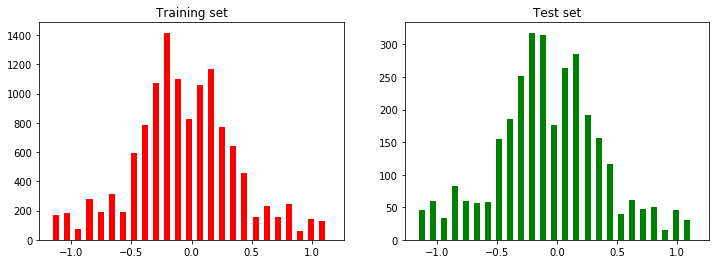

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=max_bars, width=0.05, color='red')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=max_bars, width=0.05, color='green')
axes[1].set_title('Test set')

## Data augmentation
Having a bigger dataset improves the model's precision, because the model receives more examples to train on.
Data augmentation is done by using the original dataset to create new data.
For the processing of images, there are multiple operations that can be applied to the dataset. For example, if a model is trained to detect specifc objet. The images could be rotated so that the learning is done with the original dataset plus the rotated version. The goal is to create a model that detect the object no matter its orientation.






In [8]:
def display_sbs_images(process, leftimg, rightimg):
               
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()

    axs[0].imshow(leftimg)
    axs[0].set_title('Original Image')

    axs[1].imshow(rightimg)
    axs[1].set_title(process + 'Image')

## Zoom

In [9]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

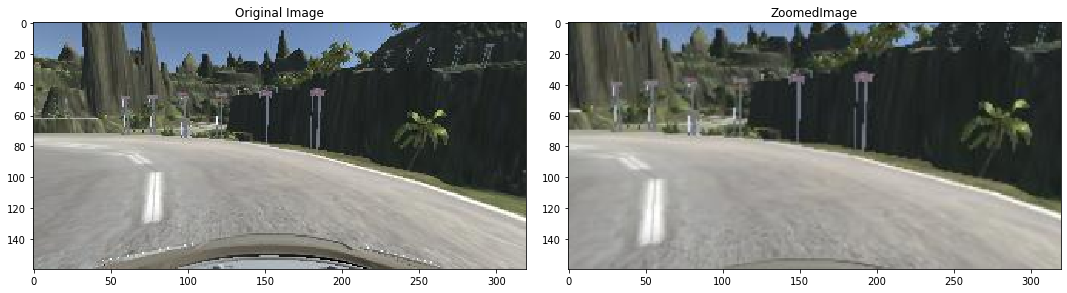

In [12]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
display_sbs_images('Zoomed', original_image, zoomed_image)

### Translation

In [15]:
def translate(image):
  translate = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = translate.augment_image(image)
  return image

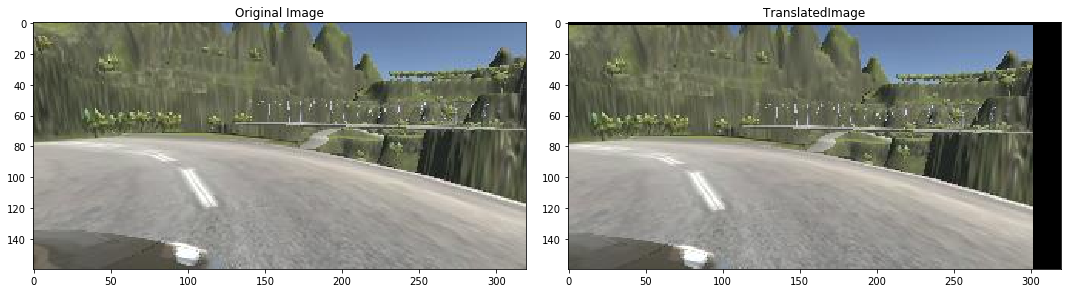

In [17]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
translated_image = translate(original_image)
display_sbs_images('Translated', original_image, translated_image)

### Brightness

In [18]:
def random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

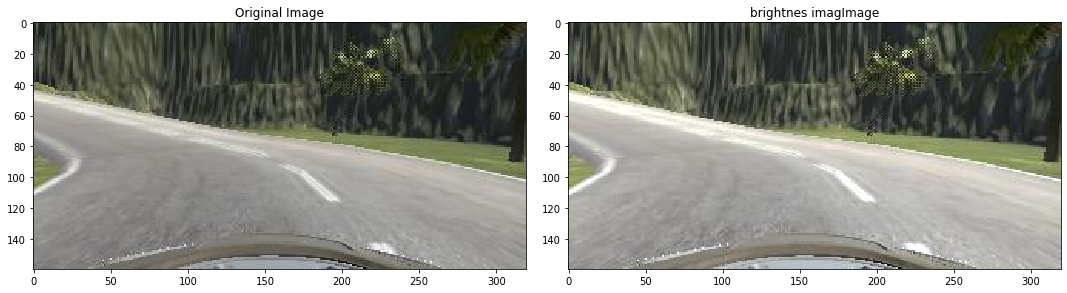

In [21]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image)
display_sbs_images('brightnes imag', original_image, brightness_altered_image)

### Flip

In [25]:
def img_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

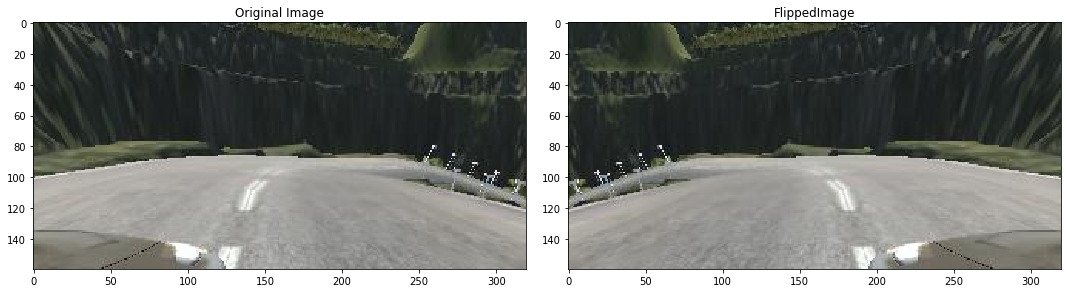

In [26]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_flip(original_image, steering_angle)
display_sbs_images('Flipped', original_image, flipped_image)


### Randomizing process

In [30]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = translate(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_flip(image, steering_angle)
    
    return image, steering_angle

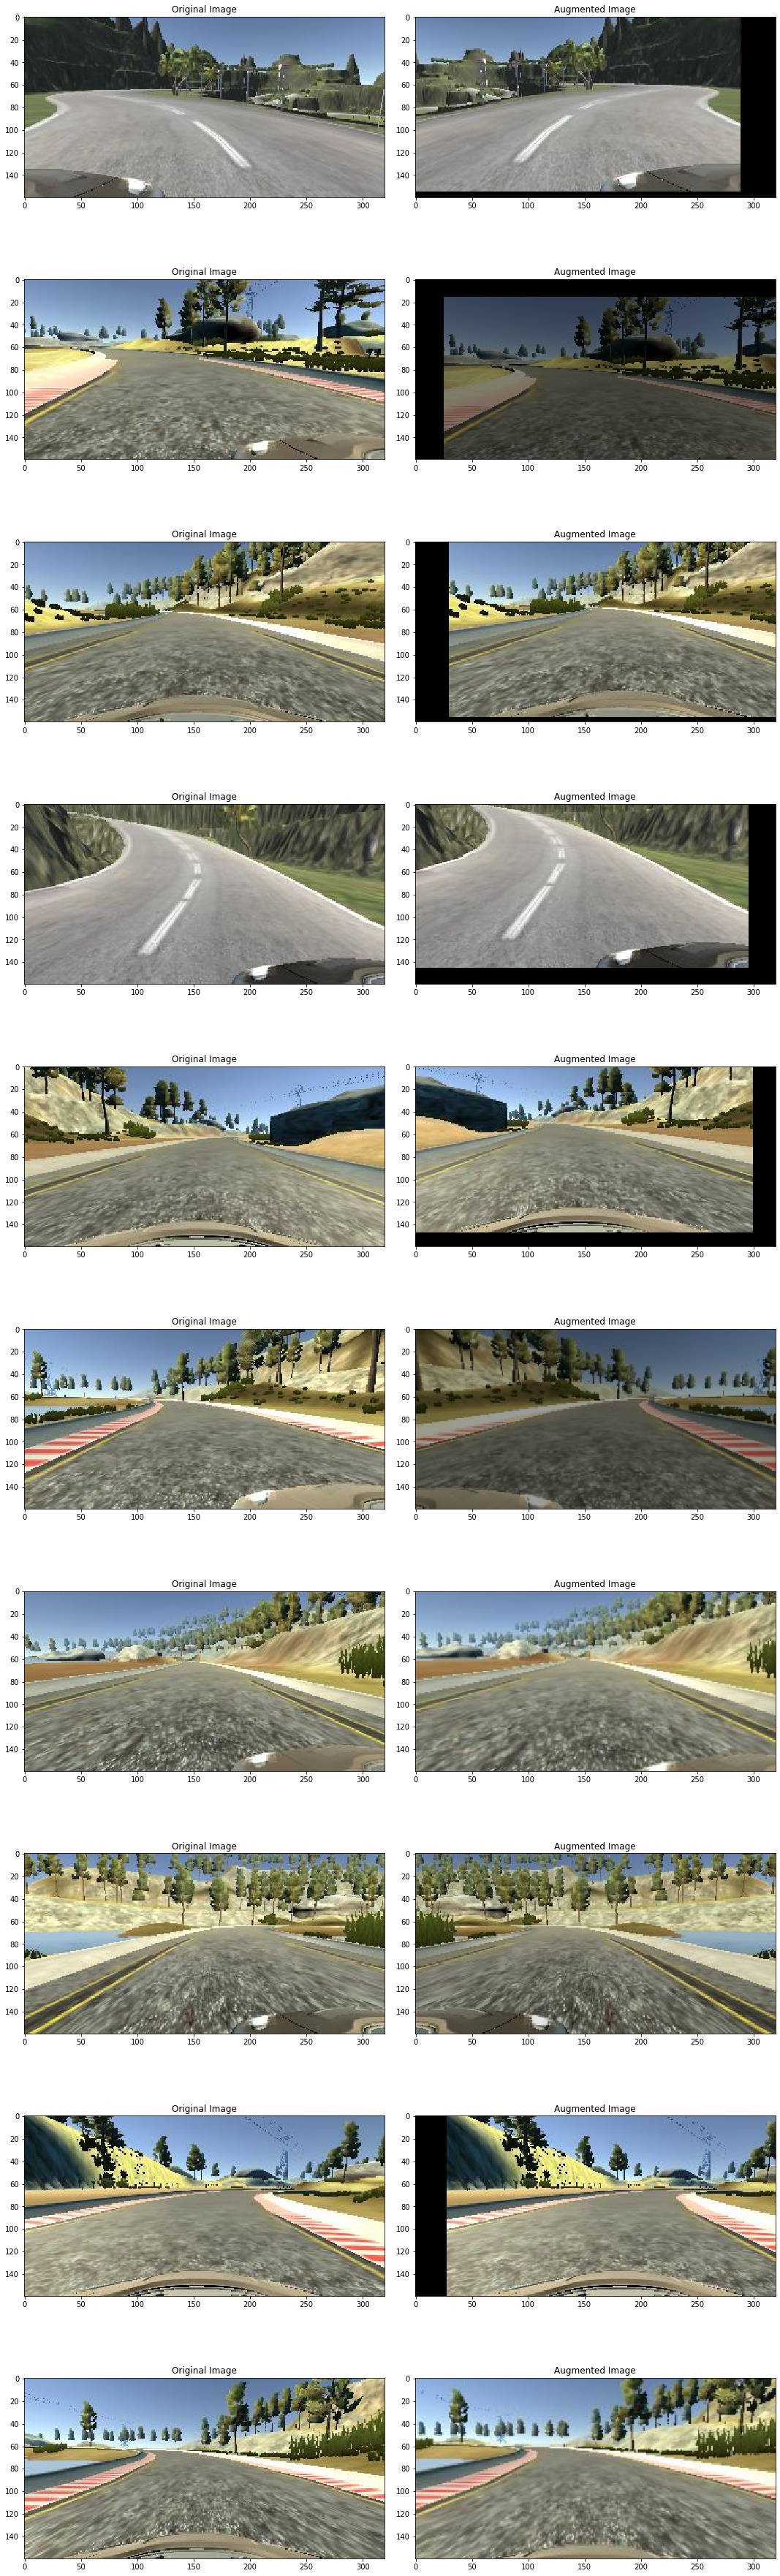

In [32]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

## Image processing

![image processing pipeline](md_images/img_pipeline.jpg)

- Crop : Delete unnecessary details on the image, only focus on the road.
- RGB 2 YUV : chromiance & lum, more bandwith and less data.
- Gaussian Blur : To smooth the image and reduce the noise
- Resize : Input datas need to be resized into specific shapes according to the model used because the convolutional kernels are adapted to a specific size
- Normalization : Decrease computational complexity



In [33]:
def img_preprocess(img, model):
    shapes =	{
      "vgg": (64, 64),
      "nvidia": (200, 66),
      "dummy": (32, 32)
    }
    img = img[60:135,:,:]
    if(model == "nvidia"):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, shapes[model])
    img = img/255
    return img

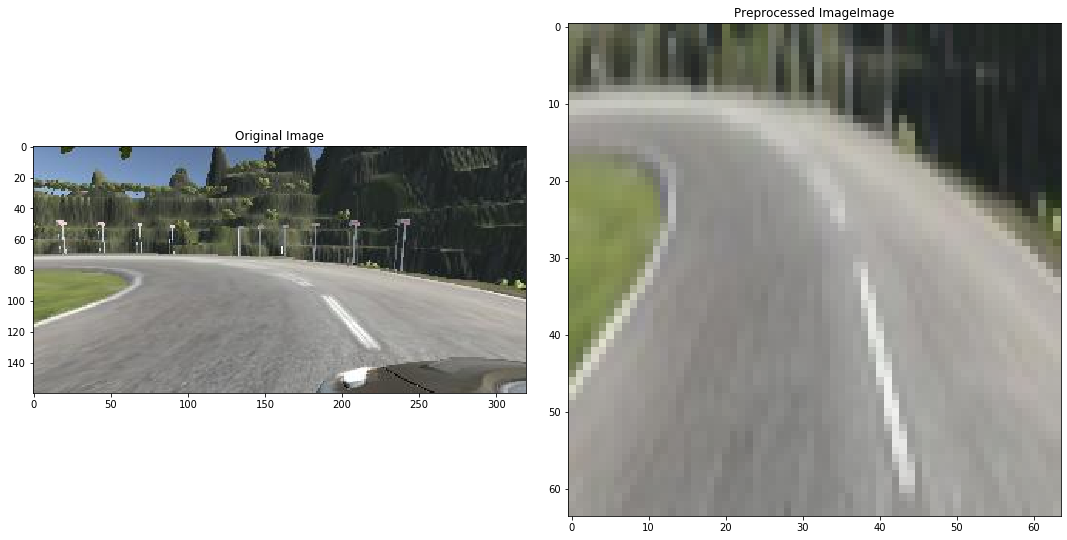

In [34]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image, 'vgg')
display_sbs_images('Preprocessed Image', original_image, preprocessed_image)

# Batch Generator

The datasets used can take soo much space that they can fit in the memory space. Most of the art-of-the-art models were trained on dataset that could not fit the memory space. To solve this problem, the Keras library provides the batch generator. It's used to split the dataset between multiple CPUs via multiprocessing and then use the data to train the model.

The batch generator is a class that will be used to split the training and the validation sets into muliple unique training and validation batches. A fonction called *fit generator* used an instance of the batch generator to create the batches, and to start the training phase. 

In [35]:
def batch_generator(image_paths, steering_ang, batch_size, istraining, model):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im, model)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

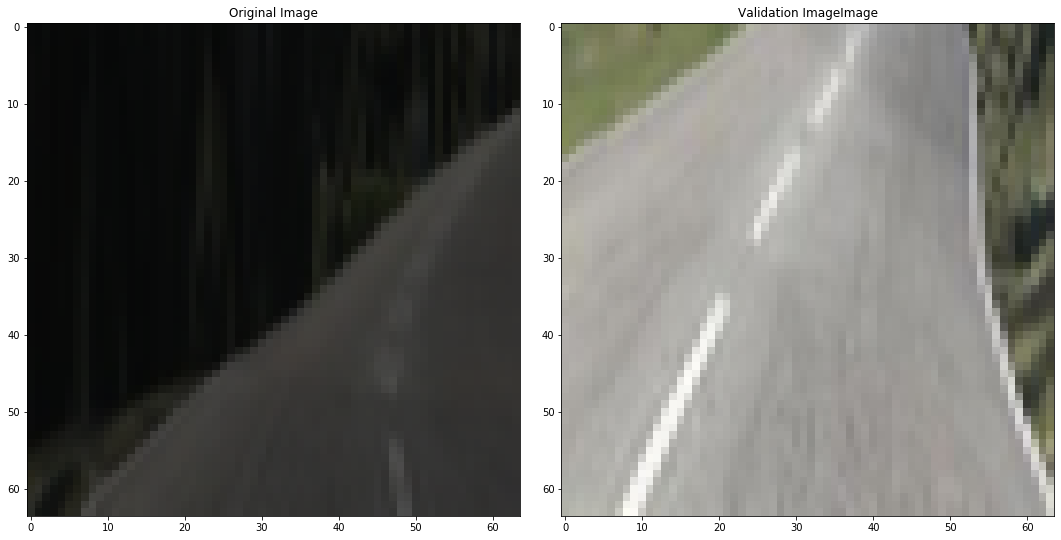

In [39]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1, 'vgg'))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0,'vgg'))
display_sbs_images('Validation Image', x_train_gen[0], x_valid_gen[0])

# Convolutional Neural Network
Type of Neural Networks developed for computation vision application. 

Each CNN learns to map images to specific classes or a specific value by updating its parameters (weights & bias).

A CNN can be composed of tree types of layers:
- A Convolutional layer
- A Pooling layer
- A Fully-connected layer: Only present once

The number of convolutional and pooling layers depends on the problem complexity. If the model has to detect low level features, those layers have to be present multiple time. But by increasing the number of layers, the required computational power is increased.

The previous layers can be combined in different ways to create different architectures. The state-of-the-art CNNs are different combination of the those layers.

## Convolutional Layer

![image processing pipeline](md_images/conv1.jpg)

The basic component of this layer is the kernel or filter. It's a matrix of defined dimension that is applied on the input image to extract features. The values of the kernel are randomly selected at the beginnning of the training, then improved during the training. 

The kernel is applied on a specific part of the image, then it's shifted by a certain distance defined by the stride value. This process is repeated until the full image has been coverred. The result of this process is a matrix called the Convolved Feature or Feature Map. There could be more than one feature map, each one extracting different features.

## Pooling Layer
![image processing pipeline](md_images/poll.jpg)

This layer is used to reduce the dimensionality of the feature map to reduce the computational complexity and to converge faster.

We used a pooling layer called Max Pooling. A matrix of a specific size is applied on some part the image, and then the maximum value in that matrix is kept. This process is repeated until the image is covered.  

The advantage of the max pooling process, is that only the dominant values are kept and the noises are removed.

## Flatten
![image processing pipeline](md_images/flat.jpg)

The flatten method is used to transform the result of the pooling layer into a column matrix.


## Dense or Fully-Connected Layer
![image processing pipeline](md_images/fc.jpg)

This layer is a classical Neural Network that learns to find the non-linear realthionship between the input and the output. The input of the this layer is the column matrix generated by the flatten method.

The last Dense layer of size 1 is the output layer.

## VGG16 Model

" Very Deep Convolutional Networks for Large-Scale Image Recognition " is one of the famous CNN image classifier model. It was orginaly designed to recognize image patterns and classify images thanks to the ImageNet huge dataset.

The model used in this project is inspired from the VGG16 architecutre and was tweaked for our needs to recognize pattern and do a regression instead of classification 

- Input shape reduced to 64x64 initially 214x214
- Reducing Conv layers (Small dataset and few features)
- Removing the softmax activation function in the last layer, beacause we do not want to classify but predict the steering angle from the features detected on the images
- Reducing the FC layer to have less parameters (4194816), since our images are small and contains few features

In [40]:
def vgg16_model(): 
    
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(64, 64, 3),padding='same'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))

    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    return model

## Nvidia Model (behavioural clonning) :

CNN architecture developed by NVIDIA researchers. Their CNN is used to map the raw pixels from a front-facing camera to the steering commands for self-driving cars using regression.

The layers are set up so that, the model learns the processing steps like detecting relevant road features.
The first layer of the CNN normalizes the input image to accelerate the GPU processing. Then the convolutional layers are used to extract features. Those layers were defined after testing multiple possible configurations. The result of the convolutional phase is sent to fully-connected layers. They map the features extracted from the previous layers to the steer angle. 






In [41]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), subsample=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), subsample=(2, 2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
#   model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [42]:
def dummy_model():
    
    model = Sequential()
    model.add(Conv2D(15, 3, 3, subsample=(2, 2), input_shape=(32,32,3), activation = 'relu'))
    model.add(Dropout(0.4))
    
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(1))
    
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
model = vgg16_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 32, 1,'vgg'),
                                  steps_per_epoch=460, 
                                  epochs=100,
                                  validation_data=batch_generator(X_valid, y_valid, 32, 0,'vgg'),
                                  validation_steps=300,
                                  verbose=1,
                                  shuffle = 1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model_vgg16_hybrid_rockissue_new_10epchs_32x1200.h5')

## Conclusion

All models were able to learn to drive on the first track accurataly. But on the VGG16 model was able to drive the car on the second track. The following figure shows the training and validation losses on the VGG16 model.

![image processing pipeline](test_val_loss_plots/Hybrid_Dataset/model_vgg16_hybrid_rockissue_new_10epchs_64x460x100.jpg)

The models has been evaluated based on the following :

- Validation Loss plot shape
- Behaviour on track 1 & 2
- Behaviour on track 2 of the simulator old version (2016) to evaluate generalization

By increasing the number of epochs the results were improved, until the model reached a plateau. We decided to stop at 100 because the driving was corretly done. To improve the model, we increased the dataset by adding parts of both tracks where the model wasn't able to drive.

In general, the VGG16 drives as good as the human and in some cases better. For example, on the second track, the VGG16 was able to take difficult turns easily and at constant speed. Furthermore, the model was able to drive the car in difficult situation were the front road could not be seen because of the road's slope. It means that either the model memorized how to drive (overfitting) or it learned to drive on the track (generalized well). We think that the latter hypothesis is correct because the VGG61 model is able to drive on both circuit.

The differences between the models on the second track are explained by their architecture

- NVIDIA: This model was created to clone the behaviour of the drive. The quality of the driving determines the accuracy of the model.
- Dummy Model: The model can be seen as a simplified NVIDIA model. Like the latter, the dummy model exctract features from the images, reduces the size to decrease the computational complexity. And the reduced result is send to a Dense layer to map teh features to the steering wheel. The NVIDIA model has more layers than the dummy model, this differene allows the former model to learn more complex information from the images.
- VGG: The model was developped to discover as much features from the images as possible. This explain why this model has better results than the two other models. The VGG model is able to learn more relevant features from the images that are later used to determine the corresponding steering angle.

## Source
- [VGG Paper](https://arxiv.org/pdf/1409.1556.pdf)
- [Nvidia Paper on self-driving system DAVE-2](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)
-	https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
-	https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2
-	https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced
-	https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
-	https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

